In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)

# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

In [4]:
data_ = load_data(download_data())
print(data_.shape)
data_.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
# 1. Look at how many unique users there are
# 2. Percentage of missing values for each feature
# 3. Distribution of the target variable
# 4. Distribution of the line balance for all users/ default users / non-default users
# 5. Summary statistics for numerical features
# 6. Distribution of the variables for each class of the target variable

In [67]:
df_clean = data_[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default.payment.next.month']].copy()
df = df_clean.rename(columns = {'default.payment.next.month':'TARGET'})

df = df[df['MARRIAGE'] != 0]  # Remove invalid marriage entries
print(df.shape)
df.head()

(29946, 7)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,TARGET
0,1,20000.0,2,2,1,24,1
1,2,120000.0,2,2,2,26,1
2,3,90000.0,2,2,2,34,0
3,4,50000.0,2,2,1,37,0
4,5,50000.0,1,2,1,57,0


In [68]:
target = 'TARGET'
feats = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

In [69]:
import pandas as pd
import numpy as np
from scipy import stats

# Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Dictionary to store outlier info
outliers_info = {}

print("Outliers detected by IQR method:")
for col in numeric_cols:
    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = {'IQR_count': outliers_iqr.shape[0]}
    print(f"{col}: {outliers_iqr.shape[0]} outliers")

print("\nOutliers detected by Z-score method (threshold=3):")
for col in numeric_cols:
    # Drop NaNs first
    col_data = df[col].dropna()
    z_scores = np.abs(stats.zscore(col_data))
    # Select outliers keeping the index aligned
    outliers_z = col_data[z_scores > 3]
    outliers_info[col]['Z_score_count'] = outliers_z.shape[0]
    print(f"{col}: {outliers_z.shape[0]} outliers")

# Optional: combine the results into a DataFrame
outliers_df = pd.DataFrame(outliers_info).T
print("\nSummary of outliers by column:")
print(outliers_df)

Outliers detected by IQR method:
ID: 0 outliers
LIMIT_BAL: 167 outliers
SEX: 0 outliers
EDUCATION: 454 outliers
MARRIAGE: 0 outliers
AGE: 272 outliers
TARGET: 6631 outliers

Outliers detected by Z-score method (threshold=3):
ID: 0 outliers
LIMIT_BAL: 130 outliers
SEX: 0 outliers
EDUCATION: 331 outliers
MARRIAGE: 0 outliers
AGE: 141 outliers
TARGET: 0 outliers

Summary of outliers by column:
           IQR_count  Z_score_count
ID                 0              0
LIMIT_BAL        167            130
SEX                0              0
EDUCATION        454            331
MARRIAGE           0              0
AGE              272            141
TARGET          6631              0


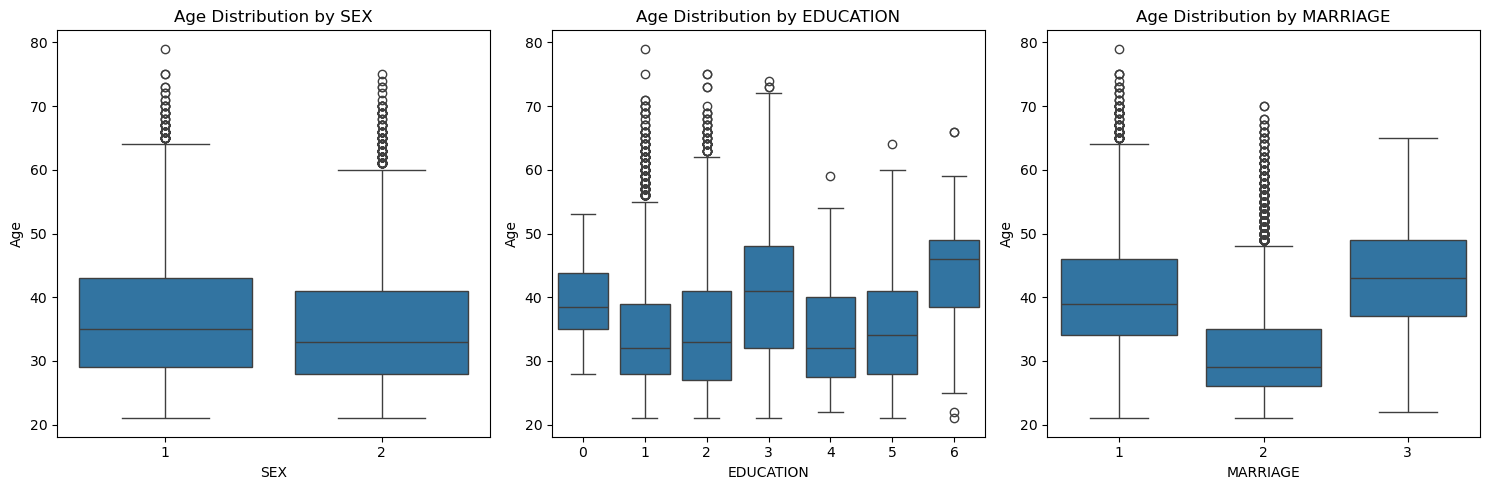

In [70]:
categorical_vars = ['SEX', 'EDUCATION', 'MARRIAGE']
numeric_var = 'AGE'

plt.figure(figsize=(15, 5))

for i, cat in enumerate(categorical_vars, 1):
    plt.subplot(1, len(categorical_vars), i)
    sns.boxplot(x=cat, y=numeric_var, data=df)
    plt.title(f'Age Distribution by {cat}')
    plt.xlabel(cat)
    plt.ylabel('Age')

plt.tight_layout()
plt.show()


From these boxplots, we can interpret the following: 
- Age distribution by sex: Both male and female groups have similar medians (~35 years), and there are few people aged above 65-70. 
- Age distribution by education: Each education range shows a simialr central range (~25-45), but there are some outliers above 60-70 years old. 
- Age distribution by marriage: There is a lower median for single people compared to the other groups. 

In [14]:
df = df.rename(columns={'LIMIT_BAL': 'CREDIT_LINE'})

In [72]:
# 1
df.ID.nunique()

29946

In [73]:
# 2
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
TARGET       0
dtype: int64

In [74]:
# 3
df[target].value_counts(normalize=True) 

TARGET
0    0.778568
1    0.221432
Name: proportion, dtype: float64

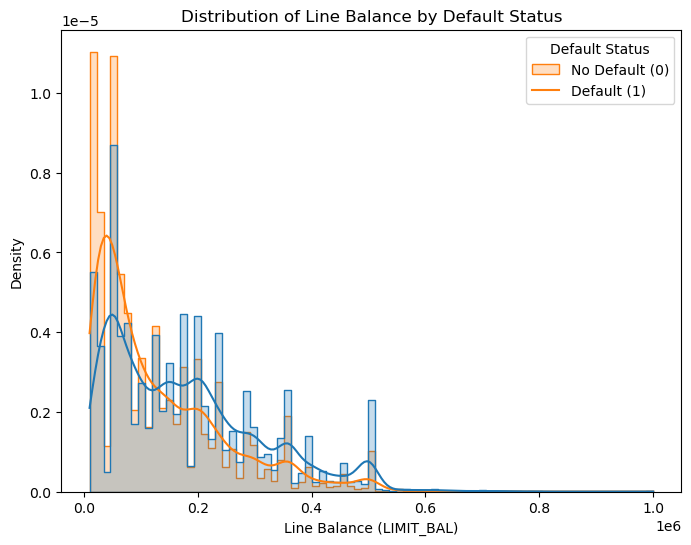

In [ ]:
# 4 
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='CREDIT_LINE', hue='TARGET', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution of Line Balance by Default Status')
plt.xlabel('Line Balance (CREDIT_LINE)')
plt.ylabel('Density')
plt.legend(title='Default Status', labels=['No Default (0)', 'Default (1)'])
plt.show()

In [ ]:

# 5
df.groupby(target).agg({'CREDIT_LINE': ['mean', 'median', 'std', 'min', 'max']})

df.groupby(target).agg({'AGE': ['mean', 'median', 'std', 'min', 'max']})

AGE                         
             mean median       std min max
TARGET                                    
0       35.417266   34.0  9.077355  21  79
1       35.725738   34.0  9.693438  21  75

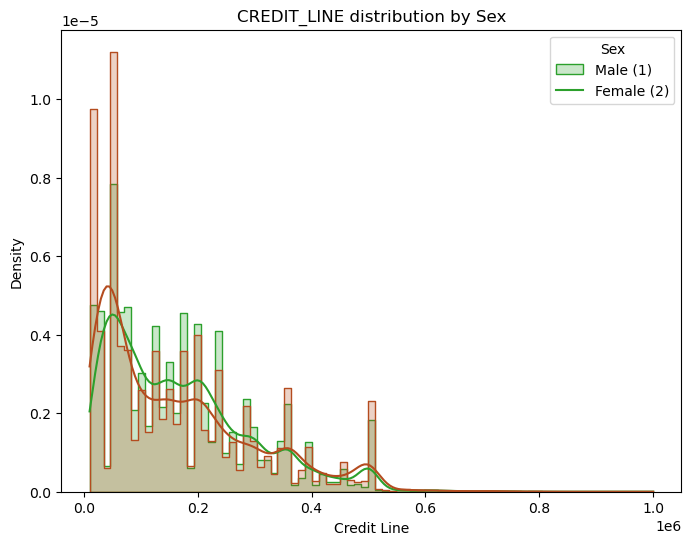

In [17]:
#6 
# CREDIT_LINE distribution by SEX
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='CREDIT_LINE', hue='SEX', kde=True, element='step', stat='density', common_norm=False, palette={1: "#b44c1f", 2: '#2ca02c'})
plt.title('CREDIT_LINE distribution by Sex')
plt.xlabel('Credit Line')
plt.ylabel('Density')
plt.legend(title='Sex', labels=['Male (1)', 'Female (2)'])
plt.show()

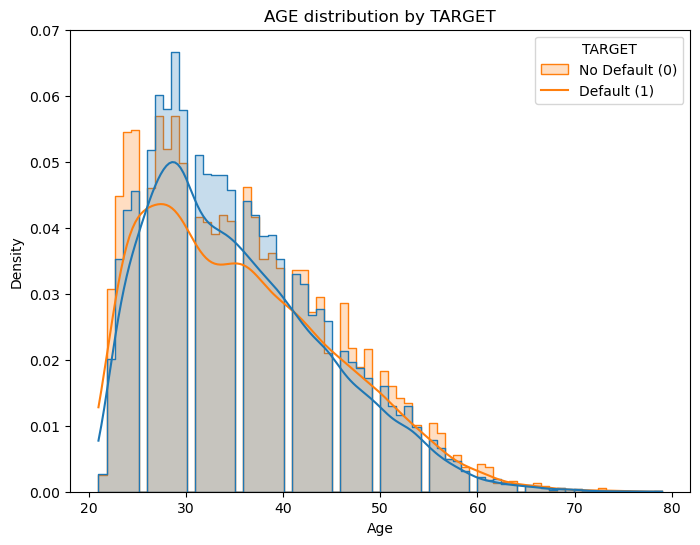

In [41]:
# Numeric distributions by TARGET: CREDIT_LINE and AGE
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='AGE', hue='TARGET', kde=True, element='step', stat='density', common_norm=False, palette={0: "#1f77b4", 1: '#ff7f0e'})
plt.title('AGE distribution by TARGET')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='TARGET', labels=['No Default (0)', 'Default (1)'])
plt.show()

In [ ]:
df_default_female = df[(df['TARGET'] == 1) & (df['SEX'] == 2)]
df_default_female = df[(df['TARGET'] == 1) & (df['SEX'] == 1)]

print(df_default_female.shape)

(2873, 7)


Text(0, 0.5, 'Count')

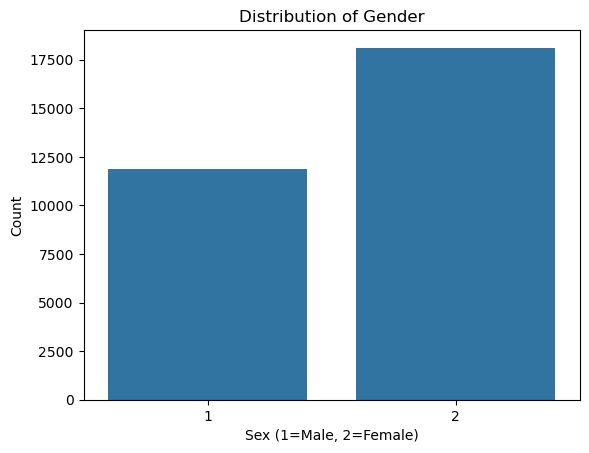

In [ ]:
# SEX Distribution
sns.countplot(x='SEX', data=df)
plt.title('Distribution of Sex')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Count')

In [40]:
df['SEX'].value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64

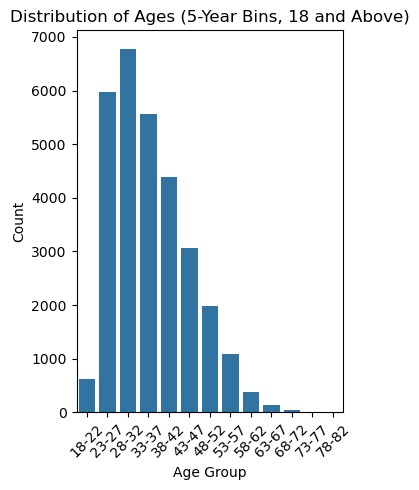

In [ ]:
# AGE Distribution with 5-Year Bins (18 and Above)
# Filter out ages below 18
df_filtered = df[df['AGE'] >= 18].copy()

# Create 5-year bins starting from 18
bins = range(18, df_filtered['AGE'].max() + 5, 5)
labels = [f"{i}-{i+4}" for i in bins[:-1]]

# Create a new column for binned ages
df_filtered['AGE_BIN'] = pd.cut(df_filtered['AGE'], bins=bins, labels=labels, right=False)

# Plot the binned data
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 3)
sns.countplot(x='AGE_BIN', data=df_filtered, order=labels)
plt.title('Distribution of Ages (5-Year Bins, 18 and Above)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count')

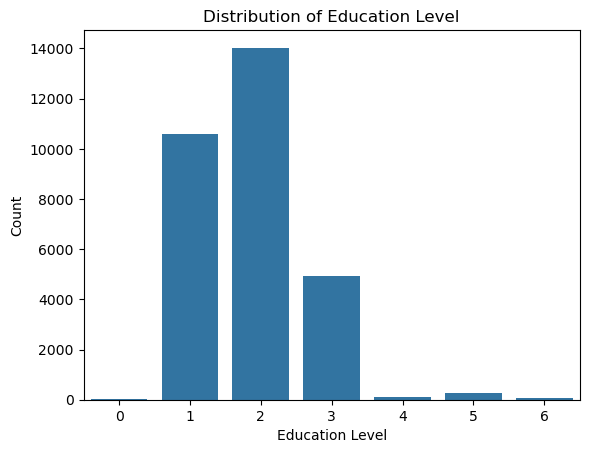

In [53]:
# EDUCATION Distribution
sns.countplot(x='EDUCATION', data=df)
plt.title('Distribution of Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')

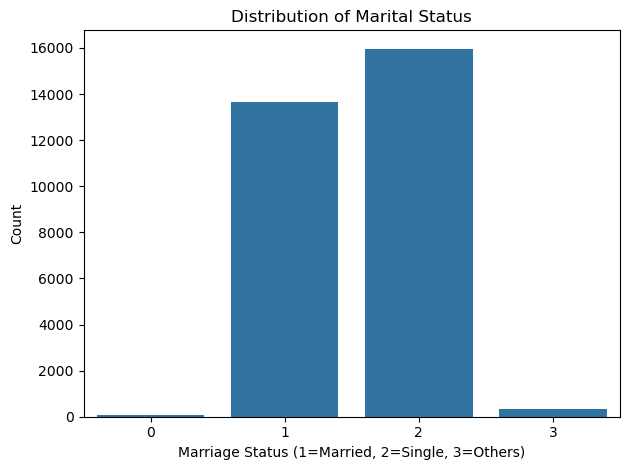

In [52]:
# MARRIAGE Distribution
sns.countplot(x='MARRIAGE', data=df)
plt.title('Distribution of Marital Status')
plt.xlabel('Marriage Status (1=Married, 2=Single, 3=Others)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

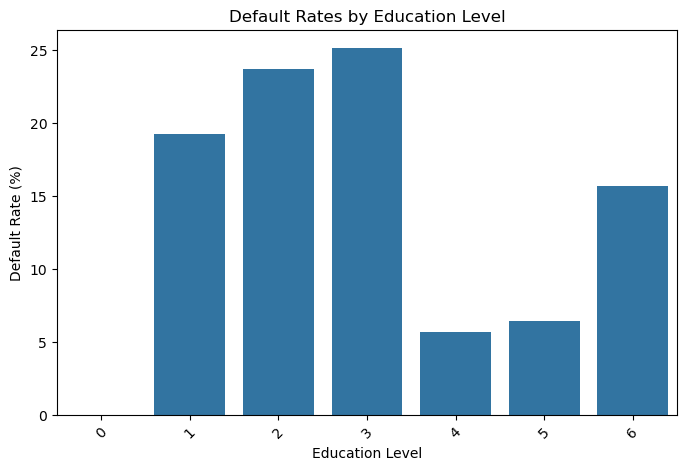

In [36]:
# Default Rate Analysis: Grouping by Education and checking default rates
default_rate = df.groupby('EDUCATION')['TARGET'].mean().reset_index()
default_rate['TARGET'] = default_rate['TARGET'] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x='EDUCATION', y='TARGET', data=default_rate)
plt.title('Default Rates by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()

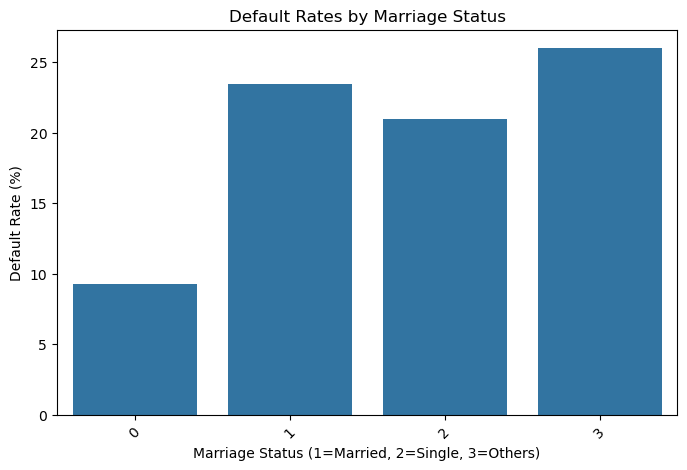

In [59]:
# Default Rate Analysis: Grouping by marriage status and checking default rates
default_rate = df.groupby('MARRIAGE')['TARGET'].mean().reset_index()
default_rate['TARGET'] = default_rate['TARGET'] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x='MARRIAGE', y='TARGET', data=default_rate)
plt.title('Default Rates by Marriage Status')
plt.xlabel('Marriage Status (1=Married, 2=Single, 3=Others)')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()

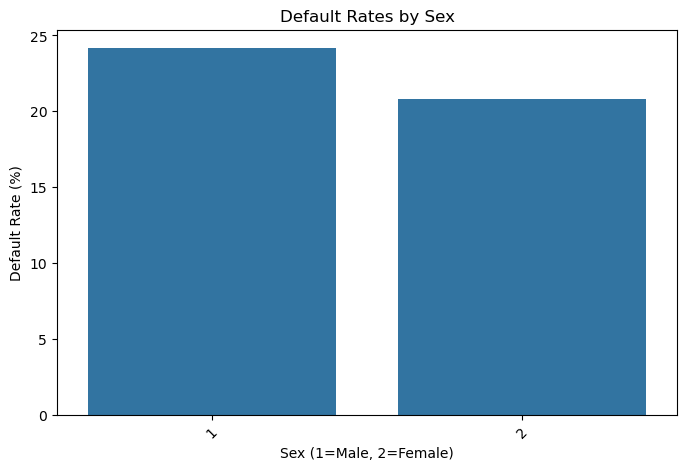

In [58]:
# Default Rate Analysis: Grouping by sex and checking default rates
default_rate = df.groupby('SEX')['TARGET'].mean().reset_index()
default_rate['TARGET'] = default_rate['TARGET'] * 100  # Percentage
plt.figure(figsize=(8, 5))
sns.barplot(x='SEX', y='TARGET', data=default_rate)
plt.title('Default Rates by Sex')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()

/var/folders/kk/mftjtndn3s9g02vfmgsch7qr0000gn/T/ipykernel_68472/1153424412.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['SEX', 'AGE_BIN'])['TARGET'].mean().reset_index()


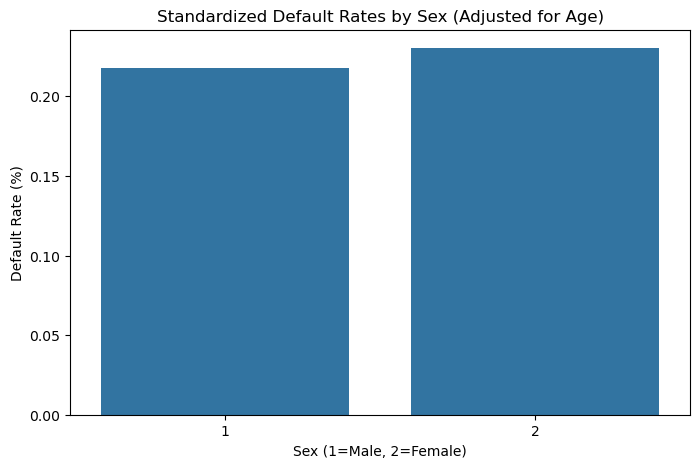

In [60]:
# Default Rate Analysis: Grouping by sex and checking default rates (standardized)
# Create 10-year age bins
bins = range(18, df['AGE'].max() + 10, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]
df['AGE_BIN'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

# Compute default rate by sex *and* age bin
grouped = df.groupby(['SEX', 'AGE_BIN'])['TARGET'].mean().reset_index()

# Compute standardized default rate (average over all age bins equally)
standardized = grouped.groupby('SEX')['TARGET'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='SEX', y='TARGET', data=standardized)
plt.title('Standardized Default Rates by Sex (Adjusted for Age)')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Default Rate (%)')
plt.show()

/var/folders/kk/mftjtndn3s9g02vfmgsch7qr0000gn/T/ipykernel_68472/1741022920.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby('AGE_BIN')['TARGET'].mean().reset_index()


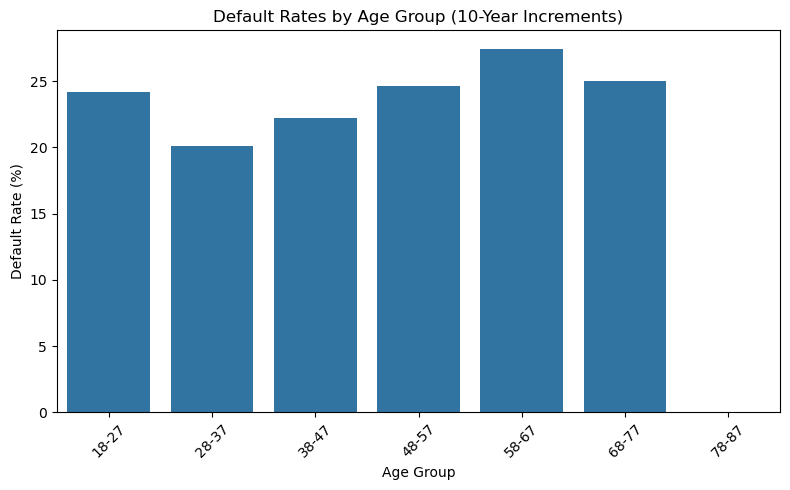

In [56]:
# Default Rate Analysis: Grouping by ages and checking default rates
# Create 10-year age bins (e.g., 18–27, 28–37, ...)
bins = range(18, df['AGE'].max() + 10, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Assign each AGE to a bin
df['AGE_BIN'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

# Compute default rates by age bin
default_rate = df.groupby('AGE_BIN')['TARGET'].mean().reset_index()
default_rate['TARGET'] = default_rate['TARGET'] * 100  # Convert to percentage

# Plot default rates by age group
plt.figure(figsize=(8, 5))
sns.barplot(x='AGE_BIN', y='TARGET', data=default_rate, order=labels)
plt.title('Default Rates by Age Group (10-Year Increments)')
plt.xlabel('Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

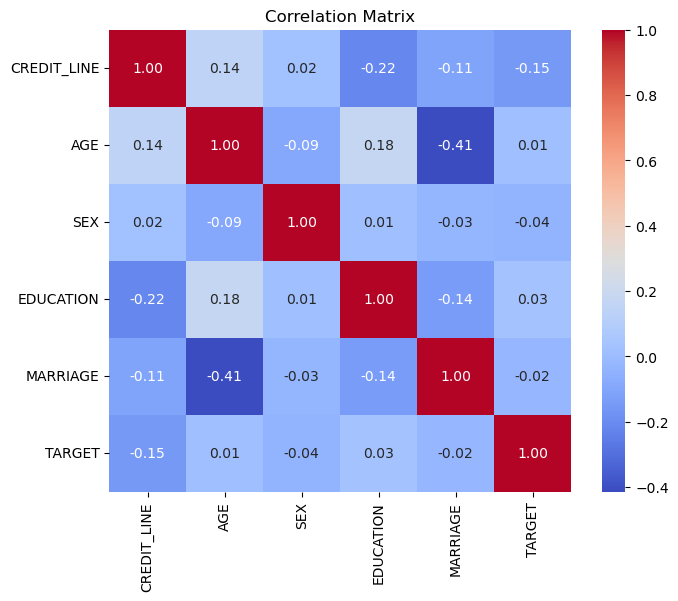

In [38]:
# Correlation Analysis: Correlation Matrix
corr = df[['CREDIT_LINE', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'TARGET']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix above illustrates the pairwise relationships between key variables, including CREDIT_LINE, AGE, SEX, EDUCATION, MARRIAGE, and the target variable (TARGET). Overall, the correlations are relatively weak, indicating that no single feature is strongly linearly related to another or to the target variable.

- CREDIT_LINE shows a slight negative correlation with TARGET (-0.15), suggesting that individuals with higher credit limits are marginally less likely to default. It also has a weak negative relationship with EDUCATION (-0.22), implying that higher education levels may be associated with higher credit limits.

- AGE has near-zero correlation with TARGET (0.01), meaning age alone is not strongly linearly related to default. However, it shows a mild positive correlation with EDUCATION (0.18) and a moderate negative correlation with MARRIAGE (-0.41), indicating that older individuals are more likely to be married and slightly more educated.

- SEX, EDUCATION, and MARRIAGE all have very weak correlations (|r| < 0.1) with TARGET, suggesting that while they may show significance in categorical tests (like the Chi-square test), their relationships are non-linear or categorical rather than continuous linear.

In [62]:
from scipy.stats import chi2_contingency
import pandas as pd

# List of categorical variables to test
categorical_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']

results = []

for var in categorical_vars:
    # Create contingency table
    contingency_table = pd.crosstab(df[var], df['TARGET'])
    
    # Run Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store results
    results.append({
        'Variable': var,
        'Chi2': chi2,
        'p-value': p,
        'Degrees of Freedom': dof,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

# Convert results to DataFrame
chi2_results = pd.DataFrame(results)
print("Chi-Square Test Results:\n")
print(chi2_results)


Chi-Square Test Results:

    Variable        Chi2       p-value  Degrees of Freedom  \
0        SEX   47.708797  4.944679e-12                   1   
1  EDUCATION  163.216558  1.233263e-32                   6   
2   MARRIAGE   35.662396  8.825862e-08                   3   
3    AGE_BIN   66.275557  2.367330e-12                   6   

  Significant (α=0.05)  
0                  Yes  
1                  Yes  
2                  Yes  
3                  Yes  


The Chi-Square test of independence was conducted to examine the relationship between several categorical variables—SEX, EDUCATION, MARRIAGE, and AGE_BIN—and the target variable (default status). The results indicated that all four variables showed statistically significant associations with default behavior at the 5% significance level. Specifically, SEX (χ² = 47.71, p < 0.001), EDUCATION (χ² = 163.22, p < 0.001), MARRIAGE (χ² = 35.66, p < 0.001), and AGE_BIN (χ² = 66.28, p < 0.001) were all found to significantly influence the likelihood of default. These findings suggest that default rates vary meaningfully across different demographic groups—by gender, education level, marital status, and age bracket. However, while these results confirm that associations exist, the Chi-Square test does not indicate the direction or strength of these relationships, nor does it imply causation. Further analysis, such as calculating effect sizes (e.g., Cramér’s V) or running multivariate logistic regression, is recommended to better understand the magnitude and independent impact of each variable on default risk.